In [ ]:
global symbol
symbol = 'AAPL'

start_date = '2020-01-01'
end_date = '2021-01-01'

In [1]:
%matplotlib inline

import backtrader as bt
import math
import supertrend
import trend
import pyfolio as pf
import yfinance as yf
import pandas as pd

import dotenv
import os
import alpaca_trade_api as alpaca


class Supertrend(bt.Strategy):
    def __init__(self):        
        dotenv.load_dotenv()
        api = alpaca.REST(os.getenv("API_KEY"), os.getenv("SECRET_KEY"), os.getenv("ENDPOINT"))
        self.bot = supertrend.Bot(api=api, symbol=symbol, backtest=True)
        self.i = 0
        self.last_call = 'HOLD'
        self.order_pct = 1
        self.backtest_data = pd.read_csv('backtesting_data.csv')
    
    def next(self):
        print(self.datetime.date(ago=0))
        
        trigger = self.bot.analysis().iloc[self.i]['ST_BUY_SELL']
        bias = trend.find_bias(symbol, backtest_data=self.backtest_data, backtest=True)
        
        if self.position.size == 0 and self.i > self.bot.lookback:                
            if trigger == "BUY" and bias == 'BUY':
                amount_to_invest = (self.order_pct * self.broker.cash)
                self.size = math.floor(amount_to_invest / self.data.close)

                print("BUY {} shares of {} at {}".format(self.size, symbol, self.data.close[0]))
                self.buy(size=self.size)
                
                self.last_call = trigger
                
            elif trigger == "SELL" and bias == 'SELL':
                amount_to_invest = (self.order_pct * self.broker.cash)
                self.size = math.floor(amount_to_invest / self.data.close)

                print("SELL {} shares of {} at {}".format(self.size, symbol, self.data.close[0]))
                self.sell(size=self.size)
                
                self.last_call = trigger
        else:
            if self.last_call == 'BUY' and trigger == 'SELL':
                self.close()
                print("Close Positions")
                
            elif self.last_call == 'SELL' and trigger == 'BUY':
                self.close()
                print("Close Positions")
                
        self.i += 1

cerebro = bt.Cerebro()
cerebro.addstrategy(Supertrend)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
cerebro.broker.setcash(10000.0)

dataframe = yf.download(symbol, start=start_date, end=end_date, interval='1d')
dataframe.to_csv('backtesting_data.csv', encoding='utf-8')

data = bt.feeds.PandasData(dataname=dataframe)    
cerebro.adddata(data)
print("Data Imported")

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]



C:\Users\ajaya\.virtualenvs\Py-Trader-s5W_jIFC\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
Data Imported
Starting Portfolio Value: 10000.00
2020-01-31
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-13
2020-04-14
BUY 139 shares of AAPL at 71.76249694824219
2020-04-15
2020-04-16
2020-04-17
2020-04-20
2020-04-21
2020-04-22
2020-0

Final Portfolio Value: 16159.77
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


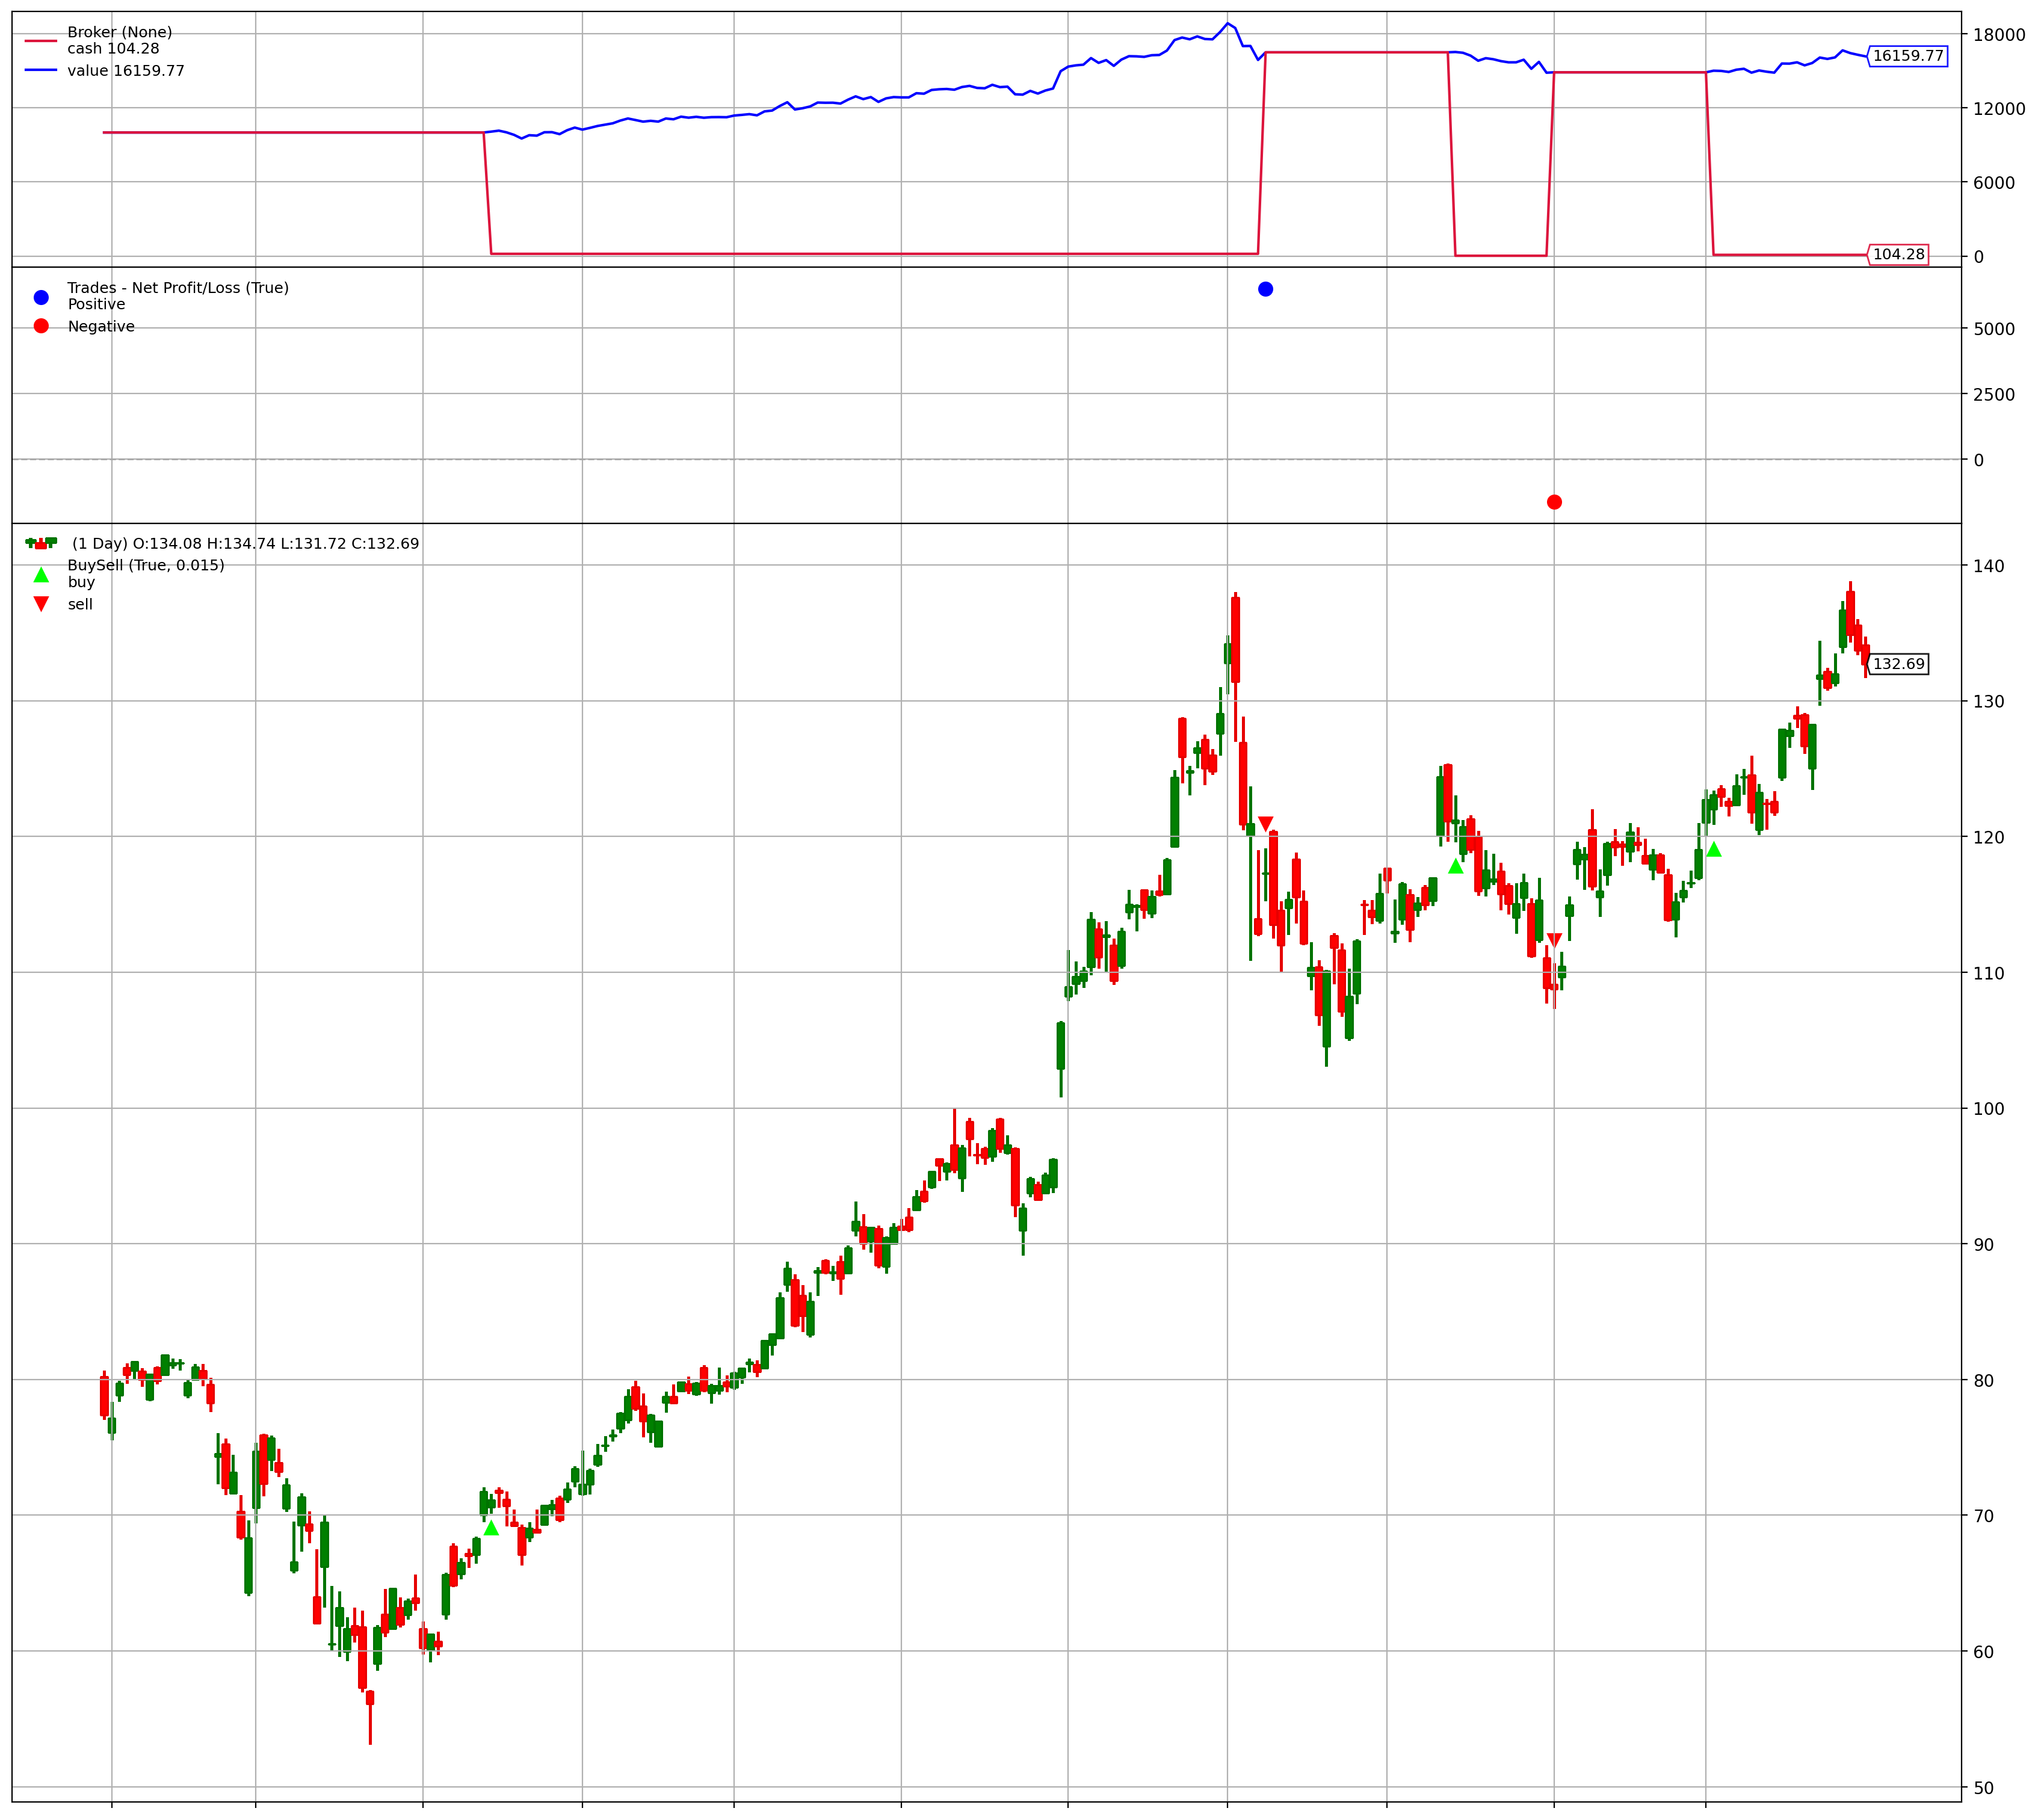

[[<Figure size 3600x3200 with 3 Axes>]]

In [4]:
%matplotlib inline
import matplotlib as plt

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[18, 16]
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'
cerebro.plot(style='candlestick', barup='green', bardown='red', volume=False, figfilename='backtrader_plot.png', iplot=False)

Start date,2020-01-31
End date,2020-12-31
Total months,11
,Backtest
Annual return,68.0%
Cumulative returns,61.6%
Annual volatility,27.6%
Sharpe ratio,2.02
Calmar ratio,3.20
Stability,0.79
Max drawdown,-21.2%


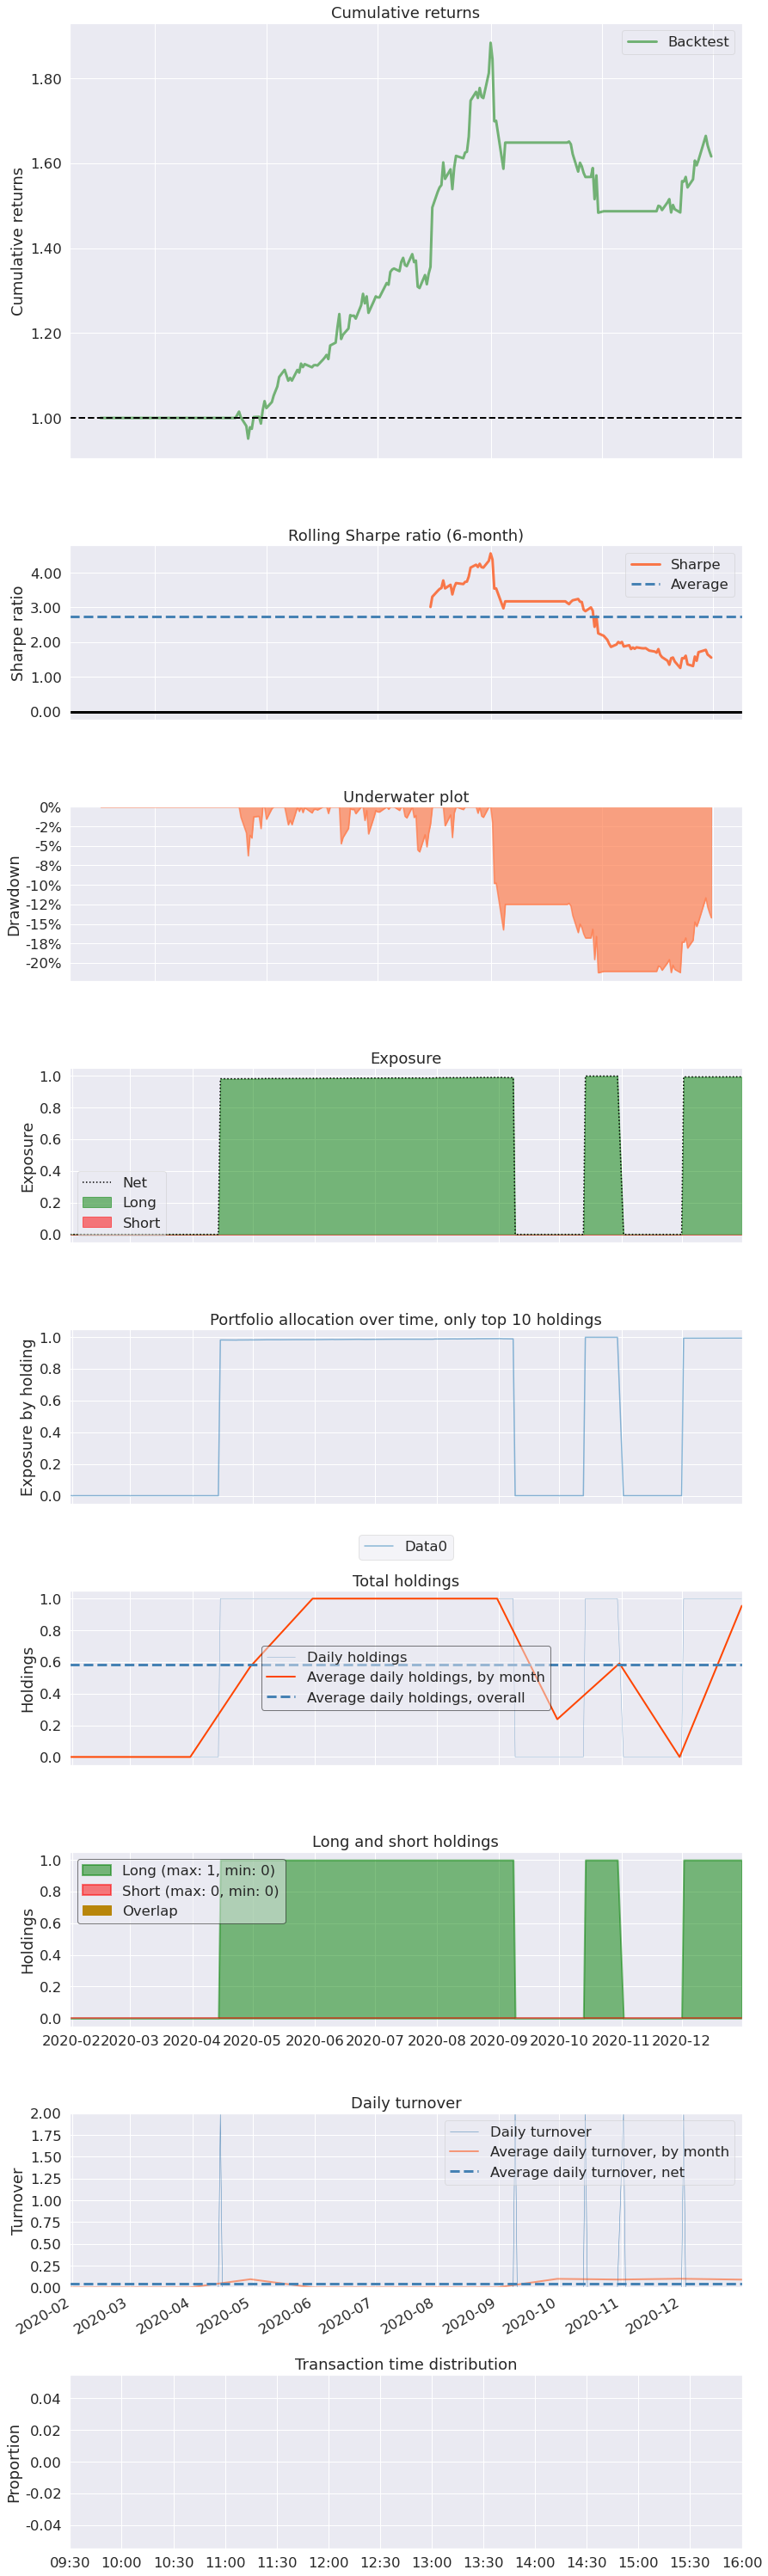

In [8]:
%matplotlib inline

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

pf.create_simple_tear_sheet(returns, positions, transactions)